<a href="https://colab.research.google.com/github/MiilouDz/Twitter-Detection/blob/main/Twitter-Community.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CIS 600, Spring 2018
## Assignment 2: Community Detection & Twitter
### Due: Friday, March 09
### Amritbani Sondhi, email: amritbani.sondhi@gmail.com

--------------------------------------------------------------------------------------------------------------------------------

### • Choose a popular Twitter account (≥ 10, 000 followers)
#### Solution:

In [ ]:
pip install twitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.8 MB/s 


Importing Libraries:

In [ ]:
import json
import pandas as pd
from twitter import *

import sys
import time
from twitter.api import TwitterHTTPError
from urllib.error import URLError
from http.client import BadStatusLine

# This will let us create new partial functions with arguments set to certain values.
from functools import partial
# This was maxint. There is no longer a maxint (in Python 3)
from sys import maxsize

Authenticating User:

In [ ]:
# Loading my authentication tokens
#with open('auth_dict','r') as f:
#   twtr_auth = json.load(f)

# To make it more readable, lets store
# the OAuth credentials in strings first.
#CONSUMER_KEY = twtr_auth['bDlpN080V191bXZPZkY5Um0zS2Q6MTpjaQ'] #consumer_key
#CONSUMER_SECRET = twtr_auth['TTa6ccSpjnuk3UkZ_QJK3AH_MpitestFHX-4OQafTM1F9xLl5h'] #consumer_secret
#OAUTH_TOKEN = twtr_auth['QyldKYLyM5LbK4Yi8AwswgvAU'] #Token
#OAUTH_TOKEN_SECRET = twtr_auth['y5MiZV1N7Kvre9T6uNtD4Ga31IOoW87xIgbAdP0xuMR7WUQX3G'] #token_secret
    
CONSUMER_KEY = "0JsGd0D5t1NxRuuOI4fK14dGI"
CONSUMER_SECRET = "kqzB9d8lWxOvqMbx0O0hrLeQyadVzkj1qHdpoNpMbjuzfUhhRn"
OAUTH_TOKEN = "1572303826299781121-kNqwOgIo721c7b7q7bcl7wv8ZG2HVm"
OAUTH_TOKEN_SECRET = "5tpFwjFE1wPVG1u1QSNKA4HW7J7GAw2wEjTbRnEL1alrj"

# Then, we store the OAuth object in "auth"
auth = OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)
# Notice that there are four tokens - you need to create these in the
# Twitter Apps dashboard after you have created your own "app".

# We now create the twitter search object.
t = Twitter(auth=auth)

Select a user to start with:

In [ ]:
popular_user =  'TheRealStanLee' # 'jimmyfallon' #'RobertDowneyJr' #'Michiel_Huisman'

--------------------------------------------------------------------------------------------------------------------------------

### • Build the friendship graph for that account’s followers
#### Solution:

In [ ]:
def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw):
    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limitingt issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
        
        if wait_period > 3600: # Seconds
            print('Too many retries. Quitting.', file=sys.stderr)
            raise e
        
        # See https://dev.twitter.com/docs/error-codes-responses for common codes
        
        if e.e.code == 401:
            print('Encountered 401 Error (Not Authorized)', file=sys.stderr)
            return None
        elif e.e.code == 404:
            print('Encountered 404 Error (Not Found)', file=sys.stderr)
            return None
        elif e.e.code == 429:
            print('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            if sleep_when_rate_limited:
                print("Retrying in 15 minutes...ZzZ...", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print('...ZzZ...Awake now and trying again.', file=sys.stderr)
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print('Encountered %i Error. Retrying in %i seconds' % (e.e.code, wait_period), file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e
    # End of nested helper function

    wait_period = 2
    error_count = 0
    while True:
        try:
            return twitter_api_func(*args, **kw)
        except TwitterHTTPError as e:
            error_count = 0
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            print("URLError encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            print >> sys.stderr, "BadStatusLine encountered. Continuing."
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise

In [ ]:
def get_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                                friends_limit=maxsize, followers_limit=maxsize):
    
    # Must have either screen_name or user_id (logical xor)
    assert (screen_name != None) != (user_id != None), \
    "Must have screen_name or user_id, but not both"
    
    # See https://dev.twitter.com/docs/api/1.1/get/friends/ids and
    # https://dev.twitter.com/docs/api/1.1/get/followers/ids for details on API parameters
    
    # You can also do this with a function closure.
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids,
                                count=5000)
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids,
                                count=5000)
    
    friends_ids, followers_ids = [], []
    
    for twitter_api_func, limit, ids, label in [
            [get_friends_ids, friends_limit, friends_ids, "friends"],
            [get_followers_ids, followers_limit, followers_ids, "followers"]
            ]:
        
        #LOOK HERE! This little line is important.
        if limit == 0: continue
        
        cursor = -1
        while cursor != 0: #and cursor != '"':
            
            # Use make_twitter_request via the partially bound callable...
            if screen_name:
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)
                
            if response is not None:
                ids += response['ids']
                cursor = response['next_cursor']
                
            print('Fetched {0} total {1} ids for {2}'.format(len(ids), label, (user_id or screen_name), file=sys.stderr))
            
            if len(ids) >= limit or response is None:
                break
                
    # Do something useful with the IDs, like store them to disk...
    return friends_ids[:friends_limit], followers_ids[:followers_limit]

In [ ]:
def crawl_followers(twitter_api, screen_name, limit=1000000, depth=2):
    
    # Resolve the ID for screen_name and start working with IDs for consistency
    seed_id = str(twitter_api.users.show(screen_name=screen_name)['id'])
    
    friend_queue, next_queue = get_friends_followers_ids(twitter_api, user_id=seed_id,
                        friends_limit=limit, followers_limit=limit)
    
    # Store followers in an object
    user_followers = dict()
    follower_list = [str(x) for x in next_queue]
    
    for line1 in follower_list:
        # here define what key is, for example,
        key = seed_id
        user_followers.setdefault(key,[]).append(line1)
    
    # Store friends in an object
    user_friends = dict()
    friend_list = [str(x) for x in friend_queue]
    
    for line2 in friend_list:
        # here define what key is, for example,
        key = seed_id
    
        #user_followers[key].append(line)
        user_friends.setdefault(key,[]).append(line2)
    
    d = 1
    while d < depth:
        
        d += 1
        
        # Reset the next_queue so that we can start building up the next level of followers-of-followers
        (queue, next_queue) = (next_queue, [])
        
        # Loop through the current level of followers
        for fid in queue:
            friendid_queue, follower_ids = get_friends_followers_ids(twitter_api, user_id=fid, friends_limit=limit, followers_limit=limit)

            # Store followers in an object
            follower_ids_list = [str(x) for x in follower_ids]

            for line3 in follower_ids_list:
                # here define what key is, for example,
                key = fid
                #user_followers[key].append(line)
                user_followers.setdefault(key,[]).append(line3)

            # Store friends in an object
            friendsid_list = [str(x) for x in friendid_queue]
    
            for line4 in friendsid_list:
                # here define what key is, for example,
                key = fid
                user_friends.setdefault(key,[]).append(line4)
        
            # Extending the list
            next_queue += follower_ids
            friend_queue += friendid_queue
            
    return user_friends, user_followers # Dicts

- __Retrieve IDs of that user's friends and followers. These are two lists. You may set the max results, as we have here, to 5000.__

In [ ]:
screen_name = popular_user
user_friends, user_followers = crawl_followers(t, screen_name, depth=2, limit=3)

Fetched 324 total friends ids for 65289126
Fetched 5000 total followers ids for 65289126
Fetched 47 total friends ids for 1497330791407407105
Fetched 0 total followers ids for 1497330791407407105


Encountered 401 Error (Not Authorized)
Encountered 401 Error (Not Authorized)


Fetched 0 total friends ids for 1429003081811996678
Fetched 0 total followers ids for 1429003081811996678
Fetched 553 total friends ids for 1427309005794418689
Fetched 135 total followers ids for 1427309005794418689


Pretty Printing the Dictionary Data

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
print('Followers Dict: ')
pp.pprint(user_followers)
print('Friends Dict: ')
pp.pprint(user_friends)

Followers Dict: 
{   1427309005794418689: [   '1561636708814290949',
                             '1560515213090250752',
                             '1543768032551510016'],
    '65289126': [   '1497330791407407105',
                    '1429003081811996678',
                    '1427309005794418689']}
Friends Dict: 
{   1427309005794418689: ['15727578', '65289126', '2398823189'],
    1497330791407407105: ['3000230307', '701635518', '2180163722'],
    '65289126': ['1471313052284829697', '9340912', '26629196']}


--------------------------------------------------------------------------------------------------------------------------------

- __Use the two friends and followers lists to find the reciprocal friends of the popular user. These are the distance-1 friends of that user.__

__Reciprocal friends__ are: mutual followers, ie. the ones you follow and the ones who follow you. __Friends__ are: the ones which you follow. __Followers__ are: the ones who follow you.

Given two sets, the intersection of the sets returns the items that they have in common. The intersection is a commutative operation. Analyzing friends and followers, the intersection of two sets can be interpreted as “mutual friends” or people you are following who are also following you back ie. Reciprocal Friends. You are likely to have much stronger affinities.

In [ ]:
def get_reciprocal_friends(user_friends, user_followers):
    set_friends= set(user_friends)
    set_followers = set(user_followers)

    # Getting User Id as it is the first element in the dictionary
    user_id = next(iter(user_friends))
    
    # get reciprocal friends at distance-1 from the popular user:
    reciprocal_friends = list(set_friends.intersection(set_followers))
    return reciprocal_friends # List

In [ ]:
# Merge the data of both lists to just ids to simplify things
all_followers_list = []
all_friends_List = []

for user_id, followers in user_followers.items():
    all_followers_list.append(int(user_id))
    for fo in range(len(followers)):
        all_followers_list.append(int(user_followers.get(user_id)[fo]))
        
for user_id, friends in user_friends.items():
    all_friends_List.append(int(user_id))
    for fo in range(len(friends)):
        all_friends_List.append(int(user_friends.get(user_id)[fo]))

In [ ]:
print("All Followers List: ")
for x in range(len(all_followers_list)):
    print(all_followers_list[x])
print("\n All Friends List: ")
for x in range(len(all_friends_List)):
    print(all_friends_List[x])

All Followers List: 
65289126
1497330791407407105
1429003081811996678
1427309005794418689
1427309005794418689
1561636708814290949
1560515213090250752
1543768032551510016

 All Friends List: 
65289126
1471313052284829697
9340912
26629196
1497330791407407105
3000230307
701635518
2180163722
1427309005794418689
15727578
65289126
2398823189


In [ ]:
# Get a list of reciprocal friends
reciprocal_friends = get_reciprocal_friends(all_friends_List, all_followers_list)
print('Reciprocal Friends: ', reciprocal_friends)

Reciprocal Friends:  [1497330791407407105, 65289126, 1427309005794418689]


--------------------------------------------------------------------------------------------------------------------------------

- __From that list of distance-1 friends, select the 5 most popular as determined by their followers_count values in user profiles. Use, for instance, the get_user_profile function from Mining the Social Web.__

In [ ]:
# Used to retreive follower count and get profile details

# Resolving user profile information
def get_user_profile(twitter_api, screen_names=None, user_ids=None):
    
    # Must have either screen_name or user_id (logical xor)
    assert (screen_names != None) != (user_ids != None), \
    "Must have screen_names or user_ids, but not both"

    items_to_info = {}
    items = screen_names or user_ids

    while len(items) > 0:
        # Process 100 items at a time per the API specifications for /users/lookup.
        # See https://dev.twitter.com/docs/api/1.1/get/users/lookup for details.
        
        items_str = ','.join([str(item) for item in items[:100]])
        items = items[100:]
        if screen_names:
            response = make_twitter_request(twitter_api.users.lookup,
                                            screen_name=items_str)
        else: # user_ids
            response = make_twitter_request(twitter_api.users.lookup,
                                            user_id=items_str)
            
        for user_info in response:
            if screen_names:
                items_to_info[user_info['screen_name']] = user_info
            else: # user_ids
                items_to_info[user_info['id']] = user_info
                
    return items_to_info

In [ ]:
# Create a list of tuples of the followers count
follower_count_list = []

if not reciprocal_friends: # Case1: if reciprocal friends are 0
    combined_friends_followers = []
    combined_friends_followers = all_followers_list + all_friends_List
    combined_friends_followers = set(combined_friends_followers)
    
    for user_id in list(combined_friends_followers):
        us_data = get_user_profile(t, user_ids=[user_id])
        us_data = json.dumps(us_data)
        us_data = json.loads(us_data)
        fo_count = us_data[str(user_id)]['followers_count']
        follower_count_list.append(((int(user_id), int(fo_count))))
    
else: #Case2: if reciprocal friends are present
    for user_id in list(reciprocal_friends):
        us_data = get_user_profile(t, user_ids=[user_id])
        us_data = json.dumps(us_data)
        us_data = json.loads(us_data)
        fo_count = us_data[str(user_id)]['followers_count']
        follower_count_list.append(((int(user_id), int(fo_count))))
    #print(follower_count_list)
    
for x in range(len(follower_count_list)):
    print(follower_count_list[x])

(1497330791407407105, 0)
(65289126, 4231895)
(1427309005794418689, 135)


In [ ]:
# Sort the follower count list, in decreasing order wrt values
sorted_count_list = sorted(follower_count_list, key=lambda fo_count: fo_count[1], reverse=True) # sort by count values
print(sorted_count_list)

[(65289126, 4231895), (1427309005794418689, 135), (1497330791407407105, 0)]


- __Get top-5 followers by user id__

In [ ]:
# Get followers for the TOP-5 in this list

def crawl_followers_by_user_id(twitter_api, user_friends, user_followers, user_id=None, limit=1000000, depth=1):
    screen_id = user_id
    friend_queue, next_queue = get_friends_followers_ids(twitter_api, user_id=screen_id,
                        friends_limit=limit, followers_limit=limit)
    
    # Store followers in an object
    #user_followers = dict()
    follower_list = [str(x) for x in next_queue]
    
    for line1 in follower_list:
        # here define what key is, for example,
        key = screen_id
        user_followers.setdefault(key,[]).append(line1)
    
    # Store friends in an object
    #user_friends = dict()
    friend_list = [str(x) for x in friend_queue]
    
    for line2 in friend_list:
        # here define what key is, for example,
        key = screen_id
        user_friends.setdefault(key,[]).append(line2)

    #null_var = ""
    #save_followers(seed_id, "'"+','.join([str(x) for x in next_queue if x is not null_var])+"'")
    
    d = 1
    list_count = 0
    tempDict = dict()
    # Note that in the example in the next cell, we never enter this loop.
    while d < depth and list_count < 100:
        d += 1
        list_count += 1
        # Reset the next_queue so that we can start building up the next level of followers-of-followers
        (queue, next_queue) = (next_queue, [])
        
        # Loop through the current level of followers
        for fid in queue:
            friendid_queue, follower_ids = get_friends_followers_ids(twitter_api, user_id=fid, friends_limit=limit, followers_limit=limit)
            
            # Store an ID with a string recording IDs of followers of the user with ID "fid"
            #save_followers(str(fid), "'"+','.join([str(x) for x in follower_ids if x is not null_var])+"'")

            # Store followers in an object
            follower_ids_list = [str(x) for x in follower_ids]

            for line3 in follower_ids_list:
                # here define what key is, for example,
                key = fid
                user_followers.setdefault(key,[]).append(line3)

            # Store friends in an object
            friendsid_list = [str(x) for x in friendid_queue]
    
            for line4 in friendsid_list:
                # here define what key is, for example,
                key = fid
                user_friends.setdefault(key,[]).append(line4)
        
            # Extending the list
            next_queue += follower_ids
            friend_queue += friendid_queue
        
        tempDict.update(user_followers)
        tempDict.update(user_friends)
        list_count = sum(len(v) for k, v in tempDict.items())
        print('Length of list: ', list_count)
    
    return user_friends, user_followers # Dicts

In [ ]:
#from collections import Counter

sorted_count_list_len = len(sorted_count_list)
print('Sorted Count List Len: ', sorted_count_list_len)

end_friends = dict()
end_followers = dict()

tempCount = 0
for item in range(sorted_count_list_len):
    while tempCount < 5 : # consider only top 5
        tempCount += 1
        userid = sorted_count_list[item][0]
        #print(userid)
        end_friends, end_followers = crawl_followers_by_user_id(t, end_friends, end_followers, user_id=userid, limit=5, depth=2)
        
print('end_friends: ',end_friends)
print('end_followers: ', end_followers)

Sorted Count List Len:  3
Fetched 324 total friends ids for 65289126
Fetched 5000 total followers ids for 65289126
Fetched 47 total friends ids for 1497330791407407105
Fetched 0 total followers ids for 1497330791407407105


Encountered 401 Error (Not Authorized)
Encountered 401 Error (Not Authorized)


Fetched 0 total friends ids for 1429003081811996678
Fetched 0 total followers ids for 1429003081811996678
Fetched 553 total friends ids for 1427309005794418689
Fetched 135 total followers ids for 1427309005794418689
Fetched 1273 total friends ids for 1535902062310879233
Fetched 1035 total followers ids for 1535902062310879233
Fetched 28 total friends ids for 1573162479915798528
Fetched 1 total followers ids for 1573162479915798528
Length of list:  25
Fetched 324 total friends ids for 65289126
Fetched 5000 total followers ids for 65289126
Fetched 47 total friends ids for 1497330791407407105
Fetched 0 total followers ids for 1497330791407407105


Encountered 401 Error (Not Authorized)
Encountered 401 Error (Not Authorized)


Fetched 0 total friends ids for 1429003081811996678
Fetched 0 total followers ids for 1429003081811996678
Fetched 553 total friends ids for 1427309005794418689
Fetched 135 total followers ids for 1427309005794418689
Fetched 1273 total friends ids for 1535902062310879233


Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


Fetched 1035 total followers ids for 1535902062310879233


...ZzZ...Awake now and trying again.


Fetched 28 total friends ids for 1573162479915798528
Fetched 1 total followers ids for 1573162479915798528
Length of list:  50
Fetched 324 total friends ids for 65289126
Fetched 5000 total followers ids for 65289126
Fetched 0 total friends ids for 1509330065741516805
Fetched 0 total followers ids for 1509330065741516805


Encountered 401 Error (Not Authorized)
Encountered 401 Error (Not Authorized)


Fetched 61 total friends ids for 1571926709657559053
Fetched 0 total followers ids for 1571926709657559053
Fetched 191 total friends ids for 1571485159299641344
Fetched 0 total followers ids for 1571485159299641344
Fetched 214 total friends ids for 748907950052413440
Fetched 11 total followers ids for 748907950052413440
Fetched 37 total friends ids for 1574337317870964736
Fetched 0 total followers ids for 1574337317870964736
Length of list:  75
Fetched 324 total friends ids for 65289126
Fetched 5000 total followers ids for 65289126
Fetched 0 total friends ids for 1509330065741516805
Fetched 0 total followers ids for 1509330065741516805


Encountered 401 Error (Not Authorized)
Encountered 401 Error (Not Authorized)


Fetched 61 total friends ids for 1571926709657559053
Fetched 0 total followers ids for 1571926709657559053
Fetched 191 total friends ids for 1571485159299641344
Fetched 0 total followers ids for 1571485159299641344
Fetched 214 total friends ids for 748907950052413440
Fetched 11 total followers ids for 748907950052413440
Fetched 37 total friends ids for 1574337317870964736
Fetched 0 total followers ids for 1574337317870964736
Length of list:  100
Fetched 324 total friends ids for 65289126
Fetched 5000 total followers ids for 65289126
Fetched 0 total friends ids for 1509330065741516805


Encountered 401 Error (Not Authorized)
Encountered 401 Error (Not Authorized)
Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


Fetched 0 total followers ids for 1509330065741516805


...ZzZ...Awake now and trying again.


Fetched 73 total friends ids for 1571926709657559053
Fetched 1 total followers ids for 1571926709657559053
Fetched 191 total friends ids for 1571485159299641344
Fetched 0 total followers ids for 1571485159299641344
Fetched 253 total friends ids for 748907950052413440
Fetched 11 total followers ids for 748907950052413440
Fetched 37 total friends ids for 1574337317870964736
Fetched 0 total followers ids for 1574337317870964736
Length of list:  125
end_friends:  {65289126: ['1471313052284829697', '9340912', '26629196', '2721644214', '1109015156955074560', '1471313052284829697', '9340912', '26629196', '2721644214', '1109015156955074560', '1471313052284829697', '9340912', '26629196', '2721644214', '1109015156955074560', '1471313052284829697', '9340912', '26629196', '2721644214', '1109015156955074560', '1471313052284829697', '9340912', '26629196', '2721644214', '1109015156955074560'], 1497330791407407105: ['3000230307', '701635518', '2180163722', '1152749683938222080', '701625379', '30002303

In [ ]:
all_end_nodes = dict(end_followers)
all_end_nodes.update(end_friends)

print(len(all_end_nodes))
pp.pprint(all_end_nodes)

9
{   65289126: [   '1471313052284829697',
                  '9340912',
                  '26629196',
                  '2721644214',
                  '1109015156955074560',
                  '1471313052284829697',
                  '9340912',
                  '26629196',
                  '2721644214',
                  '1109015156955074560',
                  '1471313052284829697',
                  '9340912',
                  '26629196',
                  '2721644214',
                  '1109015156955074560',
                  '1471313052284829697',
                  '9340912',
                  '26629196',
                  '2721644214',
                  '1109015156955074560',
                  '1471313052284829697',
                  '9340912',
                  '26629196',
                  '2721644214',
                  '1109015156955074560'],
    748907950052413440: [   '22083910',
                            '1038322449815748608',
                            '126755303078

--------------------------------------------------------------------------------------------------------------------------------

- Save the nodes (users) in a .json file

In [ ]:
import json

with open('Graph_data.json', 'w') as fp:
    json.dump(all_end_nodes, fp, indent=4)

--------------------------------------------------------------------------------------------------------------------------------

- Import the json user details of followers and friends

In [ ]:
with open('Graph_data.json', 'r') as fp:
    data = json.load(fp)

- convert the details to create a list of nodes and list of edges

In [ ]:
node_list = []

for user_id, followers in data.items():
    node_list.append(int(user_id))
    #for fo in range(len(followers)):
        #node_list.append(int(data.get(user_id)[fo]))
    node_list += followers 

#for x in range(len(node_list)):
#    print(node_list[x])

# Convert a list to a set to get the unique ids, and then back to a list
node_list = list(set(node_list))
print(len(node_list))

61


In [ ]:
edge_list = []

for user_id, followers in data.items():
    for fo in range(len(followers)):
        # clean user_id and follower id
        us_id = str(user_id).replace("'", '')
        fo_id = str(data.get(user_id)[fo]).replace("'", '')
        edge_list.append((int(us_id), int(fo_id)))

for x in range(len(edge_list)):
    print(edge_list[x])

(65289126, 1471313052284829697)
(65289126, 9340912)
(65289126, 26629196)
(65289126, 2721644214)
(65289126, 1109015156955074560)
(65289126, 1471313052284829697)
(65289126, 9340912)
(65289126, 26629196)
(65289126, 2721644214)
(65289126, 1109015156955074560)
(65289126, 1471313052284829697)
(65289126, 9340912)
(65289126, 26629196)
(65289126, 2721644214)
(65289126, 1109015156955074560)
(65289126, 1471313052284829697)
(65289126, 9340912)
(65289126, 26629196)
(65289126, 2721644214)
(65289126, 1109015156955074560)
(65289126, 1471313052284829697)
(65289126, 9340912)
(65289126, 26629196)
(65289126, 2721644214)
(65289126, 1109015156955074560)
(1427309005794418689, 15727578)
(1427309005794418689, 65289126)
(1427309005794418689, 2398823189)
(1427309005794418689, 469706697)
(1427309005794418689, 18891257)
(1427309005794418689, 15727578)
(1427309005794418689, 65289126)
(1427309005794418689, 2398823189)
(1427309005794418689, 469706697)
(1427309005794418689, 18891257)
(1535902062310879233, 65289126)
(1

--------------------------------------------------------------------------------------------------------------------------------

### • Choose a method of community detection and apply it to that graph
#### Solution:

In [ ]:
import networkx as nx
import numpy as np
import community
import matplotlib.pyplot as plt
import networkx as nx
import functools
from operator import mul

In [ ]:
G = nx.Graph()
G.add_nodes_from(node_list)
G.add_edges_from(edge_list)

In [30]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

In [35]:
from community import community_louvain
partition = community_louvain.best_partition(G)

Finds Communities with respect to Max Modularity, using Louvain's Algorithm:

In [37]:
# Computes the partition of the graph nodes which maximises the modularity using the Louvain heuristics algorithm. 
# This is the partition of highest modularity.

part = community_louvain.best_partition(G)

# Computes the modularity of a partition of a graph
mod = community_louvain.modularity(part,G)

--------------------------------------------------------------------------------------------------------------------------------

### • Produce a visual display of your graph such that nodes belonging to different communities are differently colored
#### Solution:

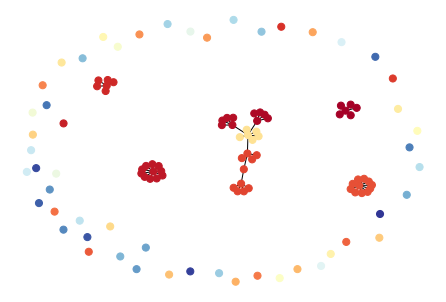

The Modularity of the Community Partitioning is:  0.8056198347107437


In [39]:
# Plot, color nodes using community structure
values = [part.get(node) for node in G.nodes()]
nx.draw_spring(G, cmap=plt.cm.RdYlBu, node_size=50, node_color = values, font_size=12, with_labels=False, font_family='sans-serif')

#nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)

#pos = nx.spring_layout(G)  # compute graph layout
#nx.draw_networkx_nodes(G, pos, node_size=30, cmap=plt.cm.RdYlBu, node_color=values)
#nx.draw_networkx_edges(G, pos,edgelist=edge_list, alpha=0.3)

plt.show()

print('The Modularity of the Community Partitioning is: ', community_louvain.modularity(part,G))

--------------------------------------------------------------------------------------------------------------------------------